Now, to begin our SVM in Python, we'll start with imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

## SVM Algorithm:
Lets start by creating a SVM class.  
- `__init__` handles few visualization related parameters.
- `fit` method will be used to train our SVM. This will also the optimization step. 
 - Here we build an optimization dictionary which is going to contain any optimization values. As we step down our w vector, we'll test that vector in our constraint function, finding the largest b, if any, that will satisfy the equation, and then we'll store all of that data in our optimization dictionary. When we're all done optimizing, we'll choose the values of w and b for whichever one in the dictionary has the lowest key value (which is ||w||). Finally, we set our transforms. The intention here is to make sure we check every version of the vector possible.
 - **Coming to convex problem.** Now, we need some starting point that matches our data. To do this, we're going to first reference our training data to pick some halfway decent starting values. All we're doing here is cycling through all of our data, and finding the highest and lowest values.
 - Next we will work on our step sizes. What we're doing here is setting some sizes per step that we want to make. For our first pass, we'll take big steps (10%). Once we find the minimum with these steps, we're going to step down to a 1% step size to continue finding the minimum here. Then, one more time, we step down to 0.1% for fine tuning. We could continue stepping down, depending on how precise you want to get. 
 - Now, we begin stepping. We begin by iterating through possible `b` values with a constant step-size. 
- `predict` method will predict the value of a new featureset once we've trained the classifier, which is just the `sign(x.w+b)` once we know what `w` and `b` are. We will also add visualization here.
- `visualize` method is used to going through our data and graphing it along with its associated color.


In [2]:
class SupportVectorMachine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1 : 'r', -1 : 'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
            
    def fit(self, data):    # The data is the data we intend to train against/optimize with. 
        self.data = data
        
        # optimization dictionary that contains { ||w||: [w,b] } where ||w|| is magnitude of w
        opt_dict = {}
        
        transforms = [[1,1],
                      [-1,1],
                      [-1,-1],
                      [1,-1]]
        
        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)
                    
        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        # no need to keep this memory.
        all_data=None
        
        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      # starts getting very high cost after this.
                      self.max_feature_value * 0.001]
        
        # set some variables that will help us make steps with b and keep track of the latest optimal value
        b_range_multiple = 5
        b_multiple = 5
        latest_optimum = self.max_feature_value * 10
        
        # begin stepping down the vector
        # to begin, we'll set optimized to False, and we'll reset this for each major step. 
        # the optimized variable will be True when we have checked all steps down to the base of the convex shape (our bowl).
        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                
                for b in np.arange(-1 * (self.max_feature_value * b_range_multiple),
                                   self.max_feature_value * b_range_multiple,
                                   step * b_multiple):
                    # now we iterate through each of the transformations, 
                    # testing each of them against our constraint requirements.
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        
                        # yi(xi.w+b) >= 1
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                if not yi*(np.dot(w_t,xi)+b) >= 1:
                                    found_option = False
                                    
                        if found_option:
                            opt_dict[np.linalg.norm(w_t)] = [w_t,b]
                            
                if w[0] < 0:
                    optimized = True
                    print('Optimized a step.')
                else:
                    w = w - step
            norms = sorted([n for n in opt_dict])
            #||w|| : [w,b]
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0] + step * 2
        
    
    def predict(self, features):
        # sign(x.w+b)
        classification = np.sign(np.dot(np.array(features), self.w) + self.b)
        
        if classification != 0 and self.visualization:
            self.ax.scatter(features[0],features[1],s=200,marker='*', c=self.colors[classification])
        else:
            print('featureset',features,'is on the decision boundary')
            
        return classification
    
    def visualize(self):
        #scattering known featuresets.
        [[self.ax.scatter(x[0],x[1],s=100,color=self.colors[i]) for x in data_dict[i]] for i in data_dict]
        
        # just for visualization purpose, not the actual hyperplane
        def hyperplane(x,w,b,v):
            # v = (w.x+b)
            return (-w[0]*x-b+v) / w[1]
        
        datarange = (self.min_feature_value*0.9,self.max_feature_value*1.1)
        hyp_x_min = datarange[0]
        hyp_x_max = datarange[1]
        
        # w.x + b = 1
        # pos sv hyperplane
        psv1 = hyperplane(hyp_x_min, self.w, self.b, 1)
        psv2 = hyperplane(hyp_x_max, self.w, self.b, 1)
        self.ax.plot([hyp_x_min,hyp_x_max], [psv1,psv2], "k")
        
        # w.x + b = -1
        # negative sv hyperplane
        nsv1 = hyperplane(hyp_x_min, self.w, self.b, -1)
        nsv2 = hyperplane(hyp_x_max, self.w, self.b, -1)
        self.ax.plot([hyp_x_min,hyp_x_max], [nsv1,nsv2], "k")

        # w.x + b = 0
        # decision
        db1 = hyperplane(hyp_x_min, self.w, self.b, 0)
        db2 = hyperplane(hyp_x_max, self.w, self.b, 0)
        self.ax.plot([hyp_x_min,hyp_x_max], [db1,db2], "g--")

        plt.show()
        

## Data
We'll have some starting data with '-1' denoting negative class and '1' denoting positive class.

In [3]:
data_dict = {-1:np.array([[1,7],
                          [2,8],
                          [3,8],]),
             
             1:np.array([[5,1],
                         [6,-1],
                         [7,3],])}

## Train, Test and Visualize
*Remeber here that the final optimization step (3rd step) takes some time because it is the costliest step in our algorithm.*

Optimized a step.
Optimized a step.
Optimized a step.


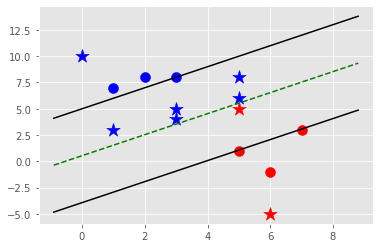

In [4]:
svm = SupportVectorMachine()
svm.fit(data=data_dict)

predict_us = [[0,10],
              [1,3],
              [3,4],
              [3,5],
              [5,5],
              [5,6],
              [6,-5],
              [5,8]]

for p in predict_us:
    svm.predict(p)

svm.visualize()

*Note: Circles are trained data and stars are predictions.*